In [94]:
#TODO:
# What if we reset the state to the original one, every 10 steps, and that would be our episode?

# Scripts

In [95]:
import argparse
from ucbq_agent import UCBQAgent
from ucbq_environment import ModifiedRandomEnvironment
import time
import numpy as np

In [96]:
# TODO:
# how do we set these?
ERR_P = 0.2
ERR_N = 0.4

# C = [
#     [0.6, 0.4],
#     [0.2, 0.8]
# ]

class PreProcessor:
    "Add noise to reward"
    def __init__(self, e_=0.1, e=0.3, normal=True, epsilon=1e-6):
        assert (np.abs(e_ + e - 1) > epsilon)
        self.normal = normal
        self.e_ = e_
        self.e = e
        self.epsilon = 1e-6
        # These are the noisy returns that are returned
        self.r1 = -1
        self.r2 = 0

    def noisy_reward(self, reward):
        n = np.random.random()
        # If we hit a negative reward, conver it to a poisitive
        # with a given prob. 
        # Not sure why the `< epsilone is here`
        # if np.abs(reward - self.r1) < self.epsilon:
        if reward == self.r1:
            if (n < self.e_):
                return self.r2
        else:
            if (n < self.e):
                return self.r1
        return reward

    def process_reward(self, reward):
        if self.normal:
            return reward

        r = self.noisy_reward(reward)
        return r
    
pre_processor = PreProcessor(normal=False, e_=ERR_N, e=ERR_P)

In [97]:
class PostProcessor:
    """
    Learning from surrogate reward
    following paper "Learning from noisy labels"
    """
    def __init__(self, smooth=False, surrogate=True,reverse=False, epsilon=1e-6):
        self.surrogate = surrogate
        self.smooth = smooth
        self.r_sets = {}
        self.r_smooth = {}
        self.r1 = -1
        self.r2 = 0
        self.counter = 0
        self.C = np.identity(2)
        self.epsilon = epsilon
        self.reverse = reverse

    def process_reward(self, reward):
        self.estimate_C()
        self.e_ = self.C[0, 1]
        self.e = self.C[1, 0]

        if self.surrogate:
            if np.abs(reward - self.r1) < self.epsilon:
                reward = ((1 - self.e) * self.r1 - self.e_ * self.r2) / (1 - self.e_ - self.e)
            else:
                reward = ((1 - self.e_) * self.r2 - self.e * self.r1) / (1 - self.e_ - self.e)

        return reward

    def estimate_C(self):
        if self.counter >= 100 and self.counter % 100 == 0:
            e_ = 0; e = 0
            # a = 0; b = 0
            # prob = 0

            self.count1 = 0
            self.count2 = 0
            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else: truth, count = freq_count.most_common()[0]
                if truth == self.r1:
                    self.count1 += len(self.r_sets[k])
                else:
                    self.count2 += len(self.r_sets[k])

            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                # if self.e_ > 0.05:
                #    self.reverse = True
                #    self.counter = 0; self.r_sets = {}
                #    break

                if self.reverse:
                    truth, count = freq_count.most_common()[-1]
                else:
                    truth, count = freq_count.most_common()[0]
                prob_correct = float(count) / len(self.r_sets[k])
                if truth == self.r1:
                    if self.count1 > 2000:
                        prob_k = float(len(self.r_sets[k])) / self.count1
                        e_ += prob_k * (1 - prob_correct)
                    else: e_ = 0.0
                    # a += 2 * prob_k * prob_correct
                else:
                    prob_k = float(len(self.r_sets[k])) / self.count2
                    e += prob_k * (1 - prob_correct)
                    # b += 2 * prob_k * prob_correct

            # print prob
            # log_string(str(e_) + " " + str(e))
            self.C = np.array([[1-e_, e_], [e, 1-e]])

            # if self.counter >= 10000:
            #     self.counter = 0
            #    self.r_sets = {}

            # print self.C

    def smooth_reward(self, state, action, reward):
        if self.smooth:
            if (state, action) in self.r_smooth:
                if len(self.r_smooth[(state, action)]) >= 100:
                    self.r_smooth[(state, action)].pop(0)
                    self.r_smooth[(state, action)].append(reward)
                    return sum(self.r_smooth[(state, action)]) / float(len(self.r_smooth[(state, action)]))
                else:
                    self.r_smooth[(state, action)].append(reward)
            else:
                self.r_smooth[(state, action)] = [reward]

        return reward

    def collect(self, state, action, reward):
        if (state, action) in self.r_sets:
            self.r_sets[(state, action)].append(reward)
        else:
            self.r_sets[(state, action)] = [reward]
        self.counter += 1

#TODO:
# Not sure if we need smoothing
# post_processor = PostProcessor(smooth=True, surrogate=True)

In [98]:
all_chart_values = []

# Params

In [99]:
# Run the script with
# `python run_experiment.py -t 1`
# This will run a simulation trial, with a total length of 1 seconds.
# Participant answere will be given every 0.001 to 0.002 seconds.
# The participant "ture" level of feedback is 2.

# The script will output:
# - A list of actions taken, in the format: 
# `elapsed_time > action_taken -> reward_received`
# - The Q-table at the end of the trial,
# with rows representing states and columns representing acions
# - The total count of given actions taken in a given state, 
# with rows representing states and columns representing acions
# - Total timesteps (actions) taken
# - Total reward obtained

# The agent is rewrded `-1` for guessing the wrong feedback level (not 2),
# and `0` for guessing correctly

# parser = argparse.ArgumentParser()
# parser.add_argument("-t", "--TimeOut", help = "Stop script after n seconds")
# args = parser.parse_args()

max_steps = 200

timeOut = None
num_states = 10
start_state = 1

In [100]:
import matplotlib.pyplot as plt

In [101]:
def runner(adjust_rewards=None):
    agent = UCBQAgent(num_states=num_states, num_actions=num_states)
    env = ModifiedRandomEnvironment(current_state = start_state, num_states=num_states)

    start_time = time.time()
    t = 0

    episode_rewards = 0

    q_values_for_chart = []
    rewards = []

    state = start_state

    while True:
        elapsed_time = time.time() - start_time

        # Auto shut down scipt 
        if bool(timeOut) and (elapsed_time > float(timeOut)):
            break

        if t > max_steps:
            break

        action = agent.choose_action(state) 
        # TODO: 
        # send_action_to_stream
        reward, next_state = env.step(action)
        
        rewards.append(reward)

        if adjust_rewards:
            reward = adjust_rewards(reward, state, action)
        
        # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
        
        agent.learn(state, action, reward, next_state)
        state = next_state

        episode_rewards += reward

        t += 1

        # if t % 10 == 0:
        #     if agent.epsilon > agent.epsilon_min:
        #         agent.epsilon *= agent.epsilon_decay # Decay epsilon

        # if agent.alpha > agent.alpha_min:
            # agent.alpha -= agent.alpha_decay(t)

        if agent.epsilon > agent.epsilon_min:
            # agent.epsilon -= agent.epsilon_decay(t)
            agent.epsilon *= 0.5

        if t % 10 == 0:
            q_values_for_chart.append(np.around(np.sum(agent.Q, axis=0), decimals=4))
            # print(agent.alpha, agent.epsilon)

    # print(f'Q-table:')
    # print(f'{np.around(agent.Q, decimals=4)}')
    # print(f'Number of times action was taken:')
    # print(f'{agent.N}')
    # print(f'Total timesteps: {sum(sum(agent.N)) - 100}')
    # print(f'Episode rewards: {episode_rewards}')

    # # plt.plot(q_values_for_chart)
    # fig = plt.gcf()
    # fig.set_size_inches(18, 4)
    # plt.plot(rewards)

    all_chart_values.append(q_values_for_chart)

    return q_values_for_chart, rewards

In [102]:
a = 20
np.log((a+1)/40)

-0.6443570163905132

In [103]:
from tqdm import tqdm 

In [104]:
import pandas as pd

In [105]:
num_episodes = 1

def plot_mean_q_values(difference_fn=None):
    q_values_all_experiments = []

    for i in tqdm(range(num_episodes)):
        q_values_for_chart, rewards = runner(difference_fn)
        q_values_all_experiments.append(q_values_for_chart)

    cumulative_sum_rewards = np.cumsum(rewards)

    time_steps = np.arange(1, len(rewards) + 1)
    mean_rewards = cumulative_sum_rewards / time_steps
    pd.DataFrame(mean_rewards).plot()

    mean_matrix = np.mean(q_values_all_experiments, axis=0)
    mean_dataframe = pd.DataFrame(mean_matrix)
    mean_dataframe.plot()

# Real rewards UCB Q-learning

In [106]:
rewards_all_experiments = []

qs, rewards = runner()
rewards_all_experiments.append(rewards)

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


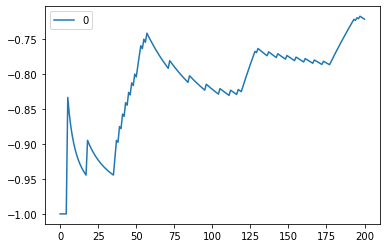

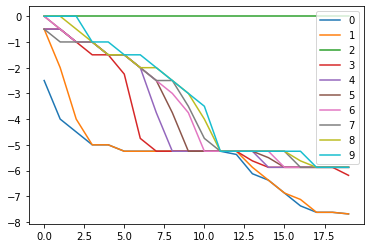

In [107]:
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [108]:
post_processor = PostProcessor(smooth=True, surrogate=True)

def adjust_rewards_noisy(reward, state, action):    
    reward = pre_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward


In [109]:
qs, rewards = runner(adjust_rewards_noisy)
rewards_all_experiments.append(rewards)

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


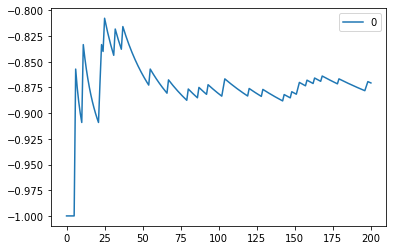

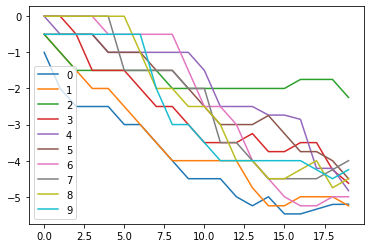

In [110]:
plot_mean_q_values(adjust_rewards_noisy)

# Surrogate rewards

In [111]:
import collections

In [112]:
post_processor = PostProcessor(smooth=True, surrogate=True)

def adjust_rewards_surrogate(reward, state, action):
    
    reward = pre_processor.process_reward(reward)
    post_processor.collect(state, action, reward)
    reward = post_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_surrogate)
print(post_processor.C)

[[1.         0.        ]
 [0.28787879 0.71212121]]


In [113]:
qs, rewards = runner(adjust_rewards_surrogate)
rewards_all_experiments.append(rewards)

100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


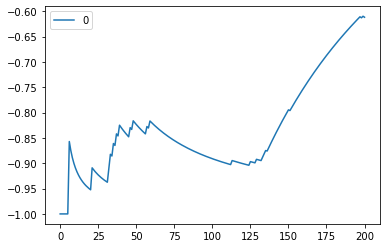

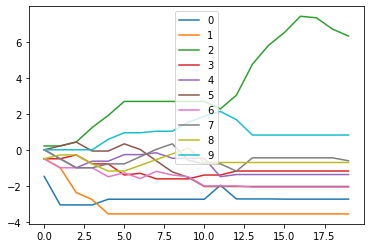

In [114]:
plot_mean_q_values(adjust_rewards_surrogate)

# Custom simplified surrogate rewards

In [115]:
#TODO
# maybe simply removing the epsilon/w/learning rate
# from the original code will give the same simplified result, as described
# in the refernce paper

class SimplePostProcessor(PostProcessor):
    """
    Learning from surrogate reward
    following paper "Learning from noisy labels"
    """
    def __init__(self, smooth=False, surrogate=True,reverse=False, epsilon=1e-6):
        self.surrogate = surrogate
        self.smooth = smooth
        self.r_sets = {}
        self.r_smooth = {}
        self.r1 = -1
        self.r2 = 0
        self.counter = 0
        self.C = np.identity(2)
        self.epsilon = epsilon
        self.reverse = reverse

    # def process_reward(self, reward):
    #     self.estimate_C()
    #     self.e_ = self.C[0, 1]
    #     self.e = self.C[1, 0]

    #     if self.surrogate:
    #         if np.abs(reward - self.r1) < self.epsilon:
    #             reward = ((1 - self.e) * self.r1 - self.e_ * self.r2) / (1 - self.e_ - self.e)
    #         else:
    #             reward = ((1 - self.e_) * self.r2 - self.e * self.r1) / (1 - self.e_ - self.e)

    #     return reward        
        
    def estimate_C(self):
        # TODO: decide on these
        min_occurances = 10
        min_count1 = 20
        if self.counter >= min_occurances and self.counter % min_occurances == 0:
            # Start estimating probabilities of error
            e_ = 0; e = 0
            # a = 0; b = 0
            # prob = 0

            self.count1 = 0
            self.count2 = 0
            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                # NOTE: 
                # we don't have this case where e > 0.5
                # if self.reverse:
                #     truth, count = freq_count.most_common()[-1]
                # else: truth, count = freq_count.most_common()[0]

                # truth = most commone reward for this (s, a)
                truth, count = freq_count.most_common()[0]

                if truth == self.r1:
                    # Count all the times we visited (s, a) as having
                    # the "true" reward
                    # i.e. the "true" count of r1
                    self.count1 += len(self.r_sets[k])
                else:
                    self.count2 += len(self.r_sets[k])

            for k in self.r_sets.keys():
                freq_count = collections.Counter(self.r_sets[k])
                # if self.e_ > 0.05:
                #    self.reverse = True
                #    self.counter = 0; self.r_sets = {}
                #    break

                # if self.reverse:
                #     truth, count = freq_count.most_common()[-1]
                # else:
                #     truth, count = freq_count.most_common()[0]
                truth, count = freq_count.most_common()[0]

                prob_correct = float(count) / len(self.r_sets[k])
                if truth == self.r1:
                    if self.count1 > min_count1:
                        prob_k = float(len(self.r_sets[k])) / self.count1
                        e_ += prob_k * (1 - prob_correct)
                    else: e_ = 0.0
                    # a += 2 * prob_k * prob_correct
                else:
                    prob_k = float(len(self.r_sets[k])) / self.count2
                    e += prob_k * (1 - prob_correct)
                    # b += 2 * prob_k * prob_correct

            # print prob
            # log_string(str(e_) + " " + str(e))
            self.C = np.array([[1-e_, e_], [e, 1-e]])

            # if self.counter >= 10000:
            #     self.counter = 0
            #    self.r_sets = {}

            # print self.C

    def collect(self, state, action, reward):
        if (state, action) in self.r_sets:
            self.r_sets[(state, action)].append(reward)
        else:
            self.r_sets[(state, action)] = [reward]
        self.counter += 1            

post_processor = SimplePostProcessor(smooth=True, surrogate=True)

def adjust_rewards_surrogate_simple(reward, state, action):    
    reward = pre_processor.process_reward(reward)
    post_processor.collect(state, action, reward)
    reward = post_processor.process_reward(reward)
    reward = post_processor.smooth_reward(state, action, reward)
    return reward

runner(adjust_rewards_surrogate_simple)

print(post_processor.C)

[[0.88541667 0.11458333]
 [0.31730769 0.68269231]]


In [116]:
qs, rewards = runner(adjust_rewards_surrogate_simple)
rewards_all_experiments.append(rewards)

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


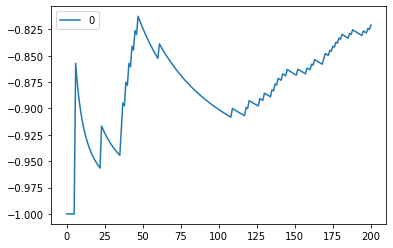

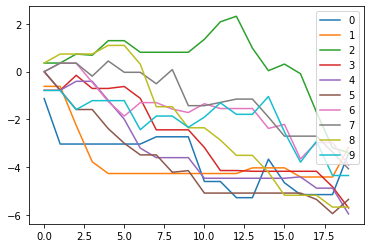

In [117]:
plot_mean_q_values(adjust_rewards_surrogate_simple)

# Q-value of "true" level compared accross different reward techniques

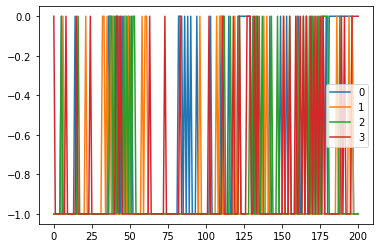

In [118]:
pd.DataFrame(rewards_all_experiments).T.plot()

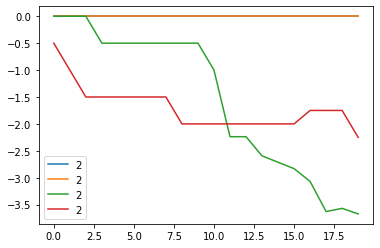

In [119]:
pd.DataFrame([
    pd.DataFrame(all_chart_values[0])[2],
    pd.DataFrame(all_chart_values[1])[2],
    pd.DataFrame(all_chart_values[2])[2],
    pd.DataFrame(all_chart_values[3])[2],
    ]).T.plot()

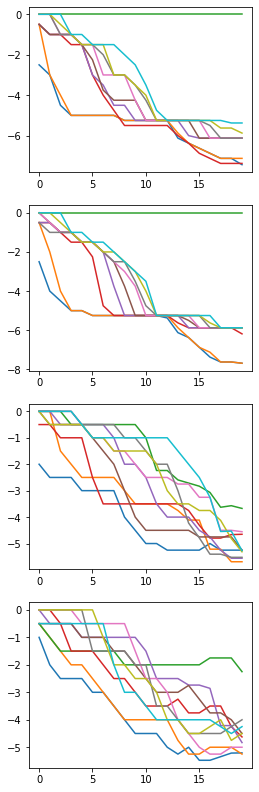

In [120]:
fig = plt.gcf()
fig.set_size_inches(4, 14)
plt.subplot(4, 1, 1)
plt.plot(all_chart_values[0])
plt.subplot(4, 1, 2)
plt.plot(all_chart_values[1])
plt.subplot(4, 1, 3)
plt.plot(all_chart_values[2])
plt.subplot(4, 1, 4)
plt.plot(all_chart_values[3])
